## The feature-based Time Series Classification Algorithm: Tracking Differentiator-based Multiview Dilated Characteristics 

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
from sktime.utils.data_io import load_from_tsfile_to_dataframe
import os
import time
from aeon.datasets import load_arrow_head

In [2]:
import numpy as np
from sklearn.linear_model import RidgeClassifierCV  # Normalize parameter is need set to True.
from sklearn.preprocessing import scale
from sklearn.feature_selection import f_classif
from aeon.transformations.collection.feature_based import TSFreshFeatureExtractor

## 1. Unsupervised base function

### (1) Dilation Mapping

In [3]:
def series_set_dilation(seriesX, d_rate=1):
    """
    Each series of the time series set is mapped by dilation mapping with 
    the same dilation rate to output the dilated time series set.

    Parameters
    ----------
    seriesX : 3D np.ndarray of shape = [n_cases, n_channels, n_timepoints] 
        The set of three dimensional time series set to be dilated.
    d_rate : int, default=1
        dilation rate.
    
    References
    ----------
    .. [1] P. Schaefer and U. Leser, “WEASEL 2.0: a random dilated dictionary 
    transform for fast, accurate and memory constrained time series classification” 
    Machine Learning, vol. 112, no. 12, pp. 4763–4788, Dec.(2024).
    """
    
    n_cases, n_channels, n_timepoints = seriesX.shape[:]
    seriesXE = np.zeros_like(seriesX)  # Initializing the dilated time series set
    
    for i in range(n_cases):
        for j in range(n_channels):
            series_ = []
            for d in range(d_rate):
                series_.append(seriesX[i, j, d::d_rate])
            seriesXE[i, j, :] = np.hstack(series_)
            
    return seriesXE  # Return the dilated time series set

### (2) Tracking Differentiator

In [4]:
def fhan(x1, x2, r, h0):
    """
    The fhan function for calculating differential signal based on optimal 
    control in tracking differentiator.

    Parameters
    ----------
    x1 : float
        State 1 of the observer.
    x2 : float
        State 2 of the observer.
    r: float
        Velocity factor used to control tracking speed.
    h0 : float
        Step size.
    
    References
    ----------
    .. [1] J. Han, “From PID to active disturbance rejection control” IEEE Trans.
    Ind. Electron., vol. 56, no. 3, pp. 900-906, Mar. (2009)..
    """
    
    d = r * h0
    d0 = d * h0
    y = x1 + h0 * x2    # Computing the differential signal
    a0 = np.sqrt(d*d + 8*r*np.abs(y))

    if np.abs(y) > d0:
        a = x2 + (a0-d) / 2.0 * np.sign(y)
    else:
        a = x2 + y/h0

    if np.abs(a) <= d:  # Computing the input u of observer
        u = -r * a / d
    else:
        u = -r * np.sign(a)

    return u, y # Return input u of observer, and differential signal y


def td(signal, r=100, k=3, h=1):
    """
    The tracking differentiator with a adjustable filter factor to 
    compute a differential signal

    Parameters
    ----------
    signal : 1D np.ndarray of shape = [n_timepoints] 
        Original time series
    r : float
        Velocity factor used to control tracking speed.
    k: float
        filter factor.
    h : float
        Step size.
    
    References
    ----------
    .. [1] J. Han, “From PID to active disturbance rejection control” IEEE Trans.
    Ind. Electron., vol. 56, no. 3, pp. 900-906, Mar. (2009)..
    """
    x1 = signal[0]   # Initializing state 1
    x2 = -(signal[1] - signal[0]) / h   # Initializing state 2

    h0 = k * h
    signalTD = np.zeros(len(signal))
    dSignal = np.zeros(len(signal))
    for i in range(len(signal)):
        v = signal[i]
        x1k = x1    
        x2k = x2    
        x1 = x1k + h*x2k  # Update state 1
        u, y = fhan(x1k-v, x2k, r, h0)   # Update input u of observer and differential signal y
        x2 = x2k + h * u  # Update state 2
        dSignal[i] = y 
        signalTD[i] = x1 
    dSignal = -dSignal / h0  # Scale transform

    return dSignal[1:]  # Return the differential signal

### Example of a tracking differentiator

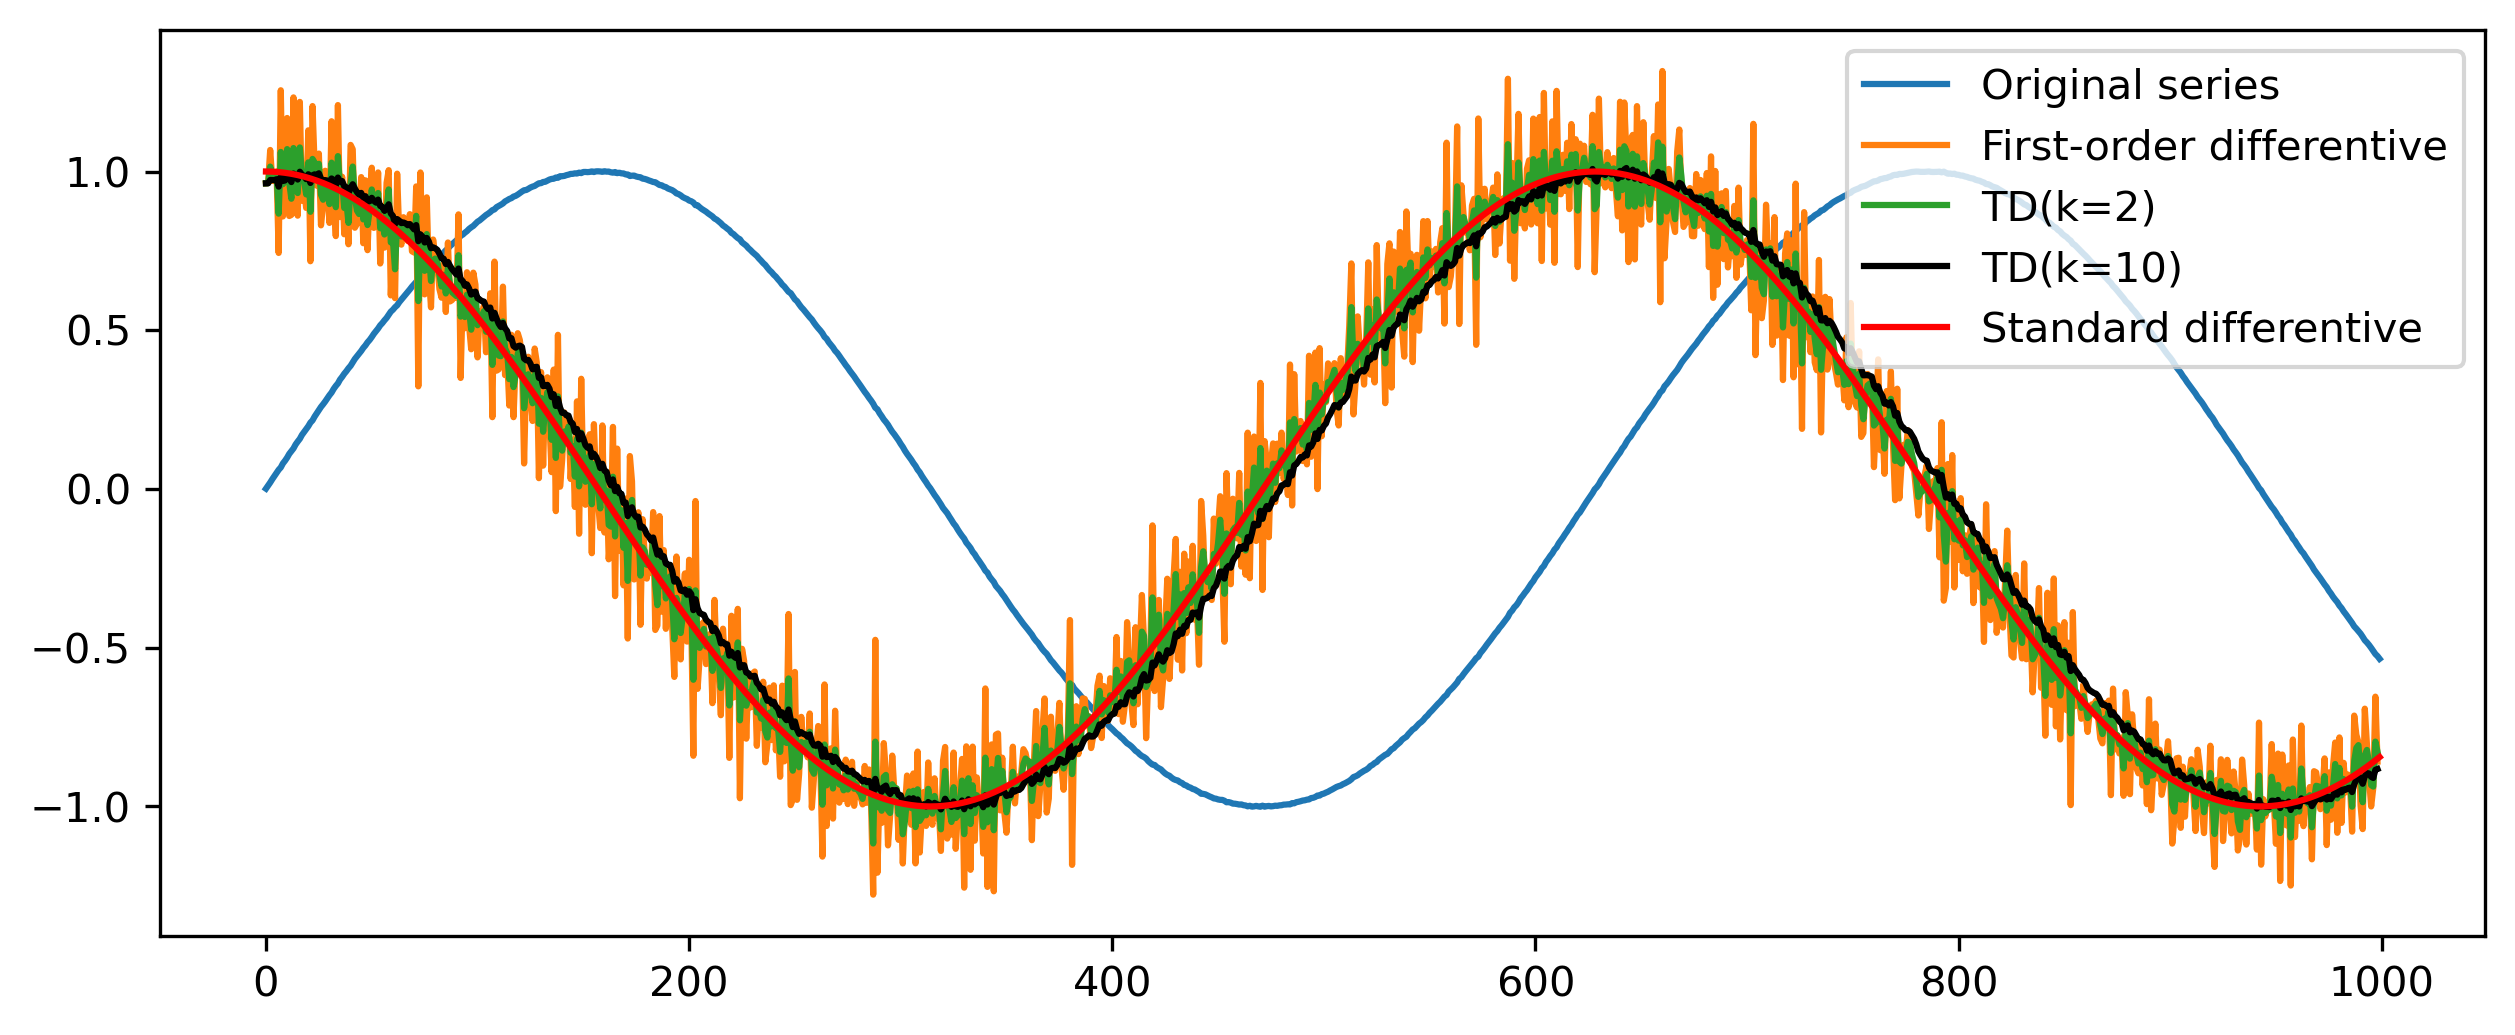

In [5]:
x = np.sin(np.arange(1000)/100) + np.random.randn(1000)/ 1000
y = np.cos(np.arange(1000)/100)

y0 = np.diff(x) * 100
y1 = td(x, k=2, h=1/100)
y2 = td(x, k=10, h=1/100)

plt.figure(figsize=(10, 4), dpi=300)
plt.plot(x, label="Original series")
plt.plot(y0, label="First-order differentive")
plt.plot(y1, label="TD(k=2)")
plt.plot(y2, label="TD(k=10)", c="k")
plt.plot(y, label="Standard differentive", c="r")
plt.legend()
plt.show()
# 

### (3) Series transform

In [6]:
def series_transform(seriesX, mode=1, k1=2, k2=2):  # 时间序列变换，包括
    """
    Each series of the time series set is transformed by tracking differentiator with 
    a adjustable filter factor to output the differential time series set.

    Parameters
    ----------
    seriesX : 3D np.ndarray of shape = [n_cases, n_channels, n_timepoints] 
        The set of three dimensional time series set to be dilated.
    mode : int, default=1
        The flag bit of a first-order or second-order derivative is used.
        Computing the first-order derivative when mode=1, 
        and computing the second-order derivative when mode=2
    k1 : float, default=2
        filter factor 1 of the tracking differentiator 1.
    k2 : float, default=2
        filter factor 2 of the tracking differentiator 2.
        This parameter is invalid when mode=1.
    
    References
    ----------
    .. [1] J. Han, “From PID to active disturbance rejection control” IEEE Trans.
    Ind. Electron., vol. 56, no. 3, pp. 900-906, Mar. (2009)..
    """

    n_cases, n_channels, n_timepoints = seriesX.shape[:]

    if mode == 1:  # First-order derivative
        seriesFX = np.zeros((n_cases, n_channels, n_timepoints-1))
        for i in range(n_cases):
            for j in range(n_channels):
                seriesFX[i, j, :] = td(seriesX[i, j, :], k=k1)
                seriesFX[i, j, :] = scale(seriesFX[i, j, :])
        return seriesFX  # Return the first-order differential time series set
    
    if mode == 2:  # Second-order derivative
        seriesSX = np.zeros((n_cases, n_channels, n_timepoints-2))
        for i in range(n_cases):
            for j in range(n_channels):
                seriesF_ = td(seriesX[i, j, :], k=k1)
                seriesSX[i, j, :] = td(seriesF_, k=k2)
                seriesSX[i, j, :] = scale(seriesSX[i, j, :])
        return seriesSX  # Return the second-order differential time series set

### (4) Hard Voting

In [7]:
def hard_voting(testYList):
    """
    The predicted labels are obtained by hard voting to process the labels matrix
    from multiple classifiers.

    Parameters
    ----------
    testYList : 2D np.ndarray of shape = [n_classifierss, n_cases]
    """
    uniqueY = np.unique(testYList)  # Holds the label for each class
    n_classes = len(uniqueY)  # Number of classes
    n_classifiers, n_cases= testYList.shape[:]  # Number of classifiers, Number of cases
    testVY = np.zeros(n_cases, int)  # 1 * n_cases, Initializing the predicted labels
   
    testWeightArray = np.zeros((n_classes, n_cases))  # n_classes * n_cases, Label weight matrix for samples
    for i in range(n_cases):
        for j in range(n_classifiers):
            label_ = testYList[j, i]
            index_ = np.arange(n_classes)[uniqueY==label_]
            testWeightArray[index_, i] += 1  # The label weight for the sample is + 1 
    for i in range(n_cases):  # Predicting each sample label
        testVY[i] = uniqueY[np.argmax(testWeightArray[:, i])]  # The label is predicted to be the most weighted
    return testVY  # return the predicted labels

## 2. Tracking Differentiator-based Multiview Dilated Characteristics

In [8]:
"""TDMVDCClassifier.

Pipeline classifier using the full set of TSFresh features and a
RotationForestClassifier.
"""

__maintainer__ = ["Changchun He"]
__all__ = ["TDMVDCClassifier"]


class TDMVDCClassifier():
    """
    Tracking Differentiator-based Multiview Dilated Characteristics 
    for Time Series Classification.

    Parameters
    ----------
    default_fc_parameters : str, default="efficient"
        Set of TSFresh features to be extracted, options are "minimal", "efficient" or
        "comprehensive".
    k1 : floot, default=2
        Filter parameter of the Tracking Differentiator1 with generating first-order 
        differential series
    k2 : floot, default=2
        Filter parameter of the Tracking Differentiator2 with generating second-order 
        differential series
    feature_store_ratios : list, default=[0.1, 0.2, 0.3, 0.4, 0.5]
        List of feature saving ratios for different feature selectors
    
    
    References
    ----------
    .. [1] Changchun He, and Xin Huo. "Tracking Differentiator-based Multiview Dilated 
        Characteristics for Time Series Classification." in The 22nd IEEE International 
        Conference on Industrial Informatics (INDIN2024) (2024).
    """

    def __init__(
        self,
        default_fc_parameters="efficient",
        k1=2,
        k2=2,
        feature_store_ratios=[0.1, 0.2, 0.3, 0.4, 0.5],
    ):
        self.default_fc_parameters = default_fc_parameters
        self.k1 = k1
        self.k2 = k2
        self.feature_store_ratios = feature_store_ratios

    def fit(self, trainSignalX, trainY):
        """Fit a pipeline on cases (trainSignalX, trainY), where trainY is the target variable.

        Parameters
        ----------
        trainSignalX : 3D np.ndarray of shape = [n_cases, n_channels, n_timepoints]
            The training data.
        trainY : array-like, shape = [n_cases]
            The class labels. Each type of label is int.

        Returns
        -------
        self :
            Reference to self.
        """
        
        # Initialization of dilation rate parameters
        n_timepoints = trainSignalX.shape[2]  # The number of time points
        d_min = 0  # The minimum dilation rate corresponds to no dilation
        d_max = int(np.log2(n_timepoints-1) - 3)  
        d_max = np.min([5, d_max])  # The maxmum dilation rate
        self.dList = 2 ** np.arange(d_min, d_max+1)  # The dilation rate list
        
        # Differential transformations by tracking differentiator
        trainSignalFX = series_transform(trainSignalX, mode=1, k1=self.k1)  # First-order differentive
        trainSignalSX = series_transform(trainSignalX, mode=2, k1=self.k1, k2=self.k2)  # Scond-order differentive

        # Feature extraction 
        self.tsFreshListR = []  # List of feature extractors corresponding to the original series set
        self.tsFreshListF = []  # List of feature extractors corresponding to the First-order differential series set
        self.tsFreshListS = []  # List of feature extractors corresponding to the Scond-order differential series set
        
        trainRXList = []  # List of train feature sets corresponding to the original series set
        trainFXList = []  # List of train feature sets corresponding to the First-order differential series set
        trainSXList = []  # List of train feature sets corresponding to the Scond-order differential series set

        for i in range(len(self.dList)):  # For each dilation rate
            print("%d/%d"%(i+1, len(self.dList)), end="  ")
            ## Dilation Mapping
            d_rate = self.dList[i]  # Dilation rate
            trainSignalRX_E = series_set_dilation(trainSignalX, d_rate)  # Dilated original series set
            trainSignalFX_E = series_set_dilation(trainSignalFX, d_rate)  # Dilated First-order differential series set
            trainSignalSX_E = series_set_dilation(trainSignalSX, d_rate)  # Dilated Scond-order differential series set

            ## Extracting the TSFresh features for each dilated series set
            tsFreshR = TSFreshFeatureExtractor(default_fc_parameters=self.default_fc_parameters)
            tsFreshR.fit(trainSignalRX_E, trainY)
            trainRX = np.array(tsFreshR.transform(trainSignalRX_E))

            tsFreshF = TSFreshFeatureExtractor(default_fc_parameters=self.default_fc_parameters)
            tsFreshF.fit(trainSignalFX_E, trainY)
            trainFX = np.array(tsFreshF.transform(trainSignalFX_E))

            tsFreshS = TSFreshFeatureExtractor(default_fc_parameters=self.default_fc_parameters)
            tsFreshS.fit(trainSignalSX_E, trainY)
            trainSX = np.array(tsFreshS.transform(trainSignalSX_E))
            
            # Saving the feature extractors
            self.tsFreshListR.append(tsFreshR)
            self.tsFreshListF.append(tsFreshF)
            self.tsFreshListS.append(tsFreshS)
            
            # Saving the TSFresh features
            trainRXList.append(trainRX)
            trainFXList.append(trainFX)
            trainSXList.append(trainSX)
        
        # Concatenating all the dilated features into a feature set
        trainRX = np.hstack((trainRXList)) # Corresponding to the original series set
        trainFX = np.hstack((trainFXList)) # Corresponding to the First-order differential series set
        trainSX = np.hstack((trainSXList)) # Corresponding to the Scond-order differential series set
        print("\t")
        
        # Classification
        self.clfList = []  # List of classifiers composed of different views

        # Computing feature scores
        self.scoreRFS = f_classif(np.hstack((trainRX, trainFX, trainSX)), trainY)[0]
        self.scoreRFS[np.isnan(self.scoreRFS)] = 0
        
        # Training the classifier on each view
        for i in range(len(self.feature_store_ratios)):  # for each view
            ratio_ = self.feature_store_ratios[i]  # The feature store ratio
            clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
            bestIndex_ = np.argsort(self.scoreRFS)[::-1][0:int(len(self.scoreRFS)*ratio_)]  # The feature indexes of the top scores
            clf.fit(np.hstack((trainRX, trainFX, trainSX))[:, bestIndex_], trainY)
            self.clfList.append(clf)  # Saving the trained classifier
        return self
    
    def predict(self, testSignalX):
        """Predict class values of n instances in testSignalX.

        Parameters
        ----------
        testSignalX : 3D np.ndarray of shape = [n_cases, n_channels, n_timepoints]
            The data to make predictions for testSignalX.

        Returns
        -------
        y : array-like, shape = [n_cases]
            Predicted class labels.
        """
        testSignalFX = series_transform(testSignalX, mode=1, k1=self.k1)  # First-order differentive
        testSignalSX = series_transform(testSignalX, mode=2, k1=self.k1, k2=self.k2)  # Second-order differentive
        
        # Feature extraction 
        testRXList = []  # List of test feature sets corresponding to the original series set
        testFXList = []  # List of test feature sets corresponding to the First-order differential series set
        testSXList = []  # List of test feature sets corresponding to the First-order differential series set
    
        for i in range(len(self.dList)):  # For each dilation rate
            print("%d/%d"%(i+1, len(self.dList)), end="  ")
            ## Dilation Mapping
            d_rate = self.dList[i]  # Dilation rate
            testSignalRX_E = series_set_dilation(testSignalX, d_rate)  # Dilated original series set
            testSignalFX_E = series_set_dilation(testSignalFX, d_rate)  # Dilated First-order differential series set
            testSignalSX_E = series_set_dilation(testSignalSX, d_rate)  # Dilated Second-order differential series set

            ## Extracting the TSFresh features for each dilated series set
            tsFreshR = self.tsFreshListR[i]
            testRX = np.array(tsFreshR.transform(testSignalRX_E))

            tsFreshF = self.tsFreshListF[i]
            testFX = np.array(tsFreshF.transform(testSignalFX_E))

            tsFreshS = self.tsFreshListS[i]
            testSX = np.array(tsFreshS.transform(testSignalSX_E))
            
            # Saving the TSFresh features
            testRXList.append(testRX)
            testFXList.append(testFX)
            testSXList.append(testSX)
            
        # Concatenating all the dilated features into a feature set
        testRX = np.hstack((testRXList)) # Corresponding to the original series set
        testFX = np.hstack((testFXList)) # Corresponding to the First-order differential series set
        testSX = np.hstack((testSXList)) # Corresponding to the Scond-order differential series set
        print("\t")
        
        # Classification
        testPYList = []  # List of predicted labels on each view
        # Predicting the labels of each view
        for i in range(len(self.feature_store_ratios)):  # for each view
            ratio_ = self.feature_store_ratios[i]  # The feature store ratio
            clf = self.clfList[i]
            bestIndex_ = np.argsort(self.scoreRFS)[::-1][0:int(len(self.scoreRFS)*ratio_)]
            testPY_ = clf.predict(np.hstack((testRX, testFX, testSX))[:, bestIndex_])  # prediction
            testPYList.append(testPY_)  # Saving the predicted labels
        testPYV = hard_voting(np.vstack((testPYList)))  # The final predicted labels is generated by hard voting
        return testPYV

## 3 Classification Example

In [9]:
# Loading time series set
from aeon.datasets import load_arrow_head
trainSignalX, trainY = load_arrow_head("TRAIN")
testSignalX, testY = load_arrow_head("TEST")
# Note that the input and output labels of our classifier are in the format of int.
trainY, testY = trainY.astype(int), testY.astype(int)

# Classification
td_mvdc = TDMVDCClassifier()
td_mvdc.fit(trainSignalX, trainY)
testPY = td_mvdc.predict(testSignalX)

# Result
accV = np.sum(testPY==testY) / len(testY)
print("Accuracy :", accV)

1/5  2/5  3/5  4/5  5/5  	
1/5  2/5  3/5  4/5  5/5  	
Accuracy : 0.8114285714285714
